# How to build a multi-agent network

<div class="admonition tip">
  <p class="admonition-title">Prerequisites</p>
  <p>
    This guide assumes familiarity with the following:
    <ul>
      <li><a href="/langgraphjs/concepts/low_level/#nodes">Nodes</a></li>
      <li><a href="/langgraphjs/concepts/low_level/#command">Command</a></li>
      <li><a href="/langgraphjs/concepts/multi_agent">Multi-agent systems</a></li>
    </ul>
    <p>
      This functionality also requires <code>@langchain/langgraph>=0.2.29</code>.
    </p>
  </p>
</div>


In this how-to guide we will demonstrate how to implement a [multi-agent network](../../concepts/multi_agent#network) architecture.

Each agent can be represented as a node in the graph that executes agent step(s) and decides what to do next - finish execution or route to another agent (including routing to itself, e.g. running in a loop). A common pattern for routing in multi-agent architectures is handoffs. Handoffs allow you to specify:

1. which agent to navigate to next and (e.g. name of the node to go to)
2. what information to pass to that agent (e.g. state update)

To implement handoffs, agent nodes can return `Command` object that allows you to [combine both control flow and state updates](/langgraphjs/how-tos/command/):

```ts
const agent = async (state) => {
  // the condition for routing/halting can be anything
  // e.g. LLM tool call / structured output, etc.
  const goto = getNextAgent(...); // "agent" / "another_agent"
  if (goto) {
    return new Command({
      goto,
      update: {
        myStateKey: "my_state_value",
      }
    });
  }
  ...
}
```

## Setup

First, let's install the required packages:

```bash
yarn add @langchain/langgraph @langchain/openai @langchain/core zod
```

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Travel Recommendations Example

In this example we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 3 agents:

* `travel_advisor`: can help with general travel destination recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.
* `sightseeing_advisor`: can help with sightseeing recommendations. Can ask `travel_advisor` and `hotel_advisor` for help.
* `hotel_advisor`: can help with hotel recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.

This is a fully-connected network - every agent can talk to any other agent. 

To implement the handoffs between the agents we'll be using LLMs with structured output. Each agent's LLM will return an output with both its text response (`response`) as well as which agent to route to next (`goto`). If the agent has enough information to respond to the user, `goto` will contain `finish`.

Now, let's define our agent nodes and graph!

In [2]:
import { ChatOpenAI } from "@langchain/openai";
import {
  Command,
  MessagesAnnotation,
  StateGraph
} from "@langchain/langgraph";

import { z } from "zod";

const model = new ChatOpenAI({
  model: "gpt-4o",
  temperature: 0.1,
});

const makeAgentNode = (params: {
  name: string,
  destinations: string[],
  systemPrompt: string
}) => {
  return async (state: typeof MessagesAnnotation.State) => {
    const possibleDestinations = ["__end__", ...params.destinations] as const;
    // define schema for the structured output:
    // - model's text response (`response`)
    // - name of the node to go to next (or '__end__')
    const responseSchema = z.object({
      response: z.string().describe(
        "A human readable response to the original question. Does not need to be a final response. Will be streamed back to the user."
      ),
      goto: z.enum(possibleDestinations).describe("The next agent to call, or __end__ if the user's query has been resolved. Must be one of the specified values."),
    });
    const messages = [
      {
        role: "system",
        content: params.systemPrompt
      },
      ...state.messages,
    ];
    const response = await model.withStructuredOutput(responseSchema, {
      name: "router",
    }).invoke(messages);

    // handoff to another agent or halt
    const aiMessage = {
      role: "assistant",
      content: response.response,
      name: params.name,
    };
    return new Command({
      goto: response.goto,
      update: { messages: aiMessage }
    });
  }
};

const travelAdvisor = makeAgentNode({
  name: "travel_advisor",
  destinations: ["sightseeing_advisor", "hotel_advisor"],
  systemPrompt: [
    "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). ",
    "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. ",
    "If you need hotel recommendations, ask 'hotel_advisor' for help. ",
    "If you have enough information to respond to the user, return '__end__'. ",
    "Never mention other agents by name."
  ].join(""),
});

const sightseeingAdvisor = makeAgentNode({
  name: "sightseeing_advisor",
  destinations: ["travel_advisor", "hotel_advisor"],
  systemPrompt: [
    "You are a travel expert that can provide specific sightseeing recommendations for a given destination. ",
    "If you need general travel help, go to 'travel_advisor' for help. ",
    "If you need hotel recommendations, go to 'hotel_advisor' for help. ",
    "If you have enough information to respond to the user, return 'finish'. ",
    "Never mention other agents by name."
  ].join(""),
});

const hotelAdvisor = makeAgentNode({
  name: "hotel_advisor",
  destinations: ["travel_advisor", "sightseeing_advisor"],
  systemPrompt: [
    "You are a booking expert that provides hotel recommendations for a given destination. ",
    "If you need general travel help, ask 'travel_advisor' for help. ",
    "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. ",
    "If you have enough information to respond to the user, return 'finish'. ",
    "Never mention other agents by name.",
  ].join(""),
});

const graph = new StateGraph(MessagesAnnotation)
  .addNode("travel_advisor", travelAdvisor, {
    ends: ["sightseeing_advisor", "hotel_advisor", "__end__"],
  })
  .addNode("sightseeing_advisor", sightseeingAdvisor, {
    ends: ["travel_advisor", "hotel_advisor", "__end__"],
  })
  .addNode("hotel_advisor", hotelAdvisor, {
    ends: ["travel_advisor", "sightseeing_advisor", "__end__"],
  })
  // we'll always start with a general travel advisor
  .addEdge("__start__", "travel_advisor")
  .compile();

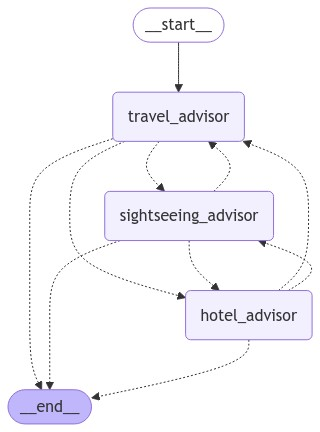

In [3]:
import * as tslab from "tslab";

const drawableGraph = await graph.getGraphAsync();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

First, let's invoke it with a generic input:

In [4]:
const simpleStream = await graph.stream({
  messages: [{
    role: "user",
    content: "i wanna go somewhere warm in the caribbean",
  }],
});

for await (const chunk of simpleStream) {
  console.log(chunk);
}

{
  travel_advisor: {
    messages: {
      role: 'assistant',
      content: 'The Caribbean is a fantastic choice for warm weather and beautiful beaches. Some popular destinations include Jamaica, the Bahamas, the Dominican Republic, and Barbados. Each offers unique experiences, from vibrant culture and music to stunning natural landscapes.',
      name: 'travel_advisor'
    }
  }
}


You can see that in this case only the first agent (`travel_advisor`) ran. Let's now ask for more recommendations:

In [5]:
const recommendationStream = await graph.stream({
  messages: [{
    role: "user",
    content: "i wanna go somewhere warm in the caribbean. pick one destination, give me some things to do and hotel recommendations",
  }],
});

for await (const chunk of recommendationStream) {
  console.log(chunk);
}

{
  travel_advisor: {
    messages: {
      role: 'assistant',
      content: 'I recommend visiting Aruba, a beautiful Caribbean island known for its stunning beaches and warm climate.',
      name: 'travel_advisor'
    }
  }
}
{
  sightseeing_advisor: {
    messages: {
      role: 'assistant',
      content: 'Aruba is a fantastic choice for a warm Caribbean getaway. Here are some activities you can enjoy:\n' +
        '\n' +
        "1. **Eagle Beach**: Relax on one of the world's most beautiful beaches, known for its pristine white sand and clear turquoise waters.\n" +
        '\n' +
        '2. **Arikok National Park**: Explore this national park that covers nearly 20% of the island, offering hiking trails, caves, and unique wildlife.\n' +
        '\n' +
        '3. **Palm Beach**: Enjoy water sports, beach bars, and vibrant nightlife along this bustling beach area.\n' +
        '\n' +
        '4. **Oranjestad**: Visit the colorful capital city for shopping, dining, and exploring lo

Voila - `travel_advisor` makes a decision to first get some sightseeing recommendations from `sightseeing_advisor`, and then `sightseeing_advisor` in turn calls `hotel_advisor` for more info. Notice that we never explicitly defined the order in which the agents should be executed!

## Game NPCs Example

In this example we will create a team of [non-player characters (NPCs)](https://en.wikipedia.org/wiki/Non-player_character) that all run at the same time and share game state (resources). At each step, each NPC will inspect the state and decide whether to halt or continue acting at the next step. If it continues, it will update the shared game state (produce or consume resources).

We will create 4 NPC agents:

- `villager`: produces wood and food until there is enough, then halts
- `guard`: protects gold and consumes food. When there is not enough food, leaves duty and halts
- `merchant`: trades wood for gold. When there is not enough wood, halts
- `thief`: checks if the guard is on duty and steals all of the gold when the guard leaves, then halts

Our NPC agents will be simple node functions (`villager`, `guard`, etc.). At each step of the graph execution, the agent function will inspect the resource values in the state and decide whether it should halt or continue. If it decides to continue, it will update the resource values in the state and loop back to itself to run at the next step.

Now, let's define our agent nodes and graph!

In [6]:
import { Command, StateGraph, Annotation } from "@langchain/langgraph";

const GameStateAnnotation = Annotation.Root({
  // note that we're defining a reducer (operator.add) here.
  // This will allow all agents to write their updates for resources concurrently.
  wood: Annotation<number>({
    default: () => 0,
    reducer: (a, b) => a + b,
  }),
  food: Annotation<number>({
    default: () => 0,
    reducer: (a, b) => a + b,
  }),
  gold: Annotation<number>({
    default: () => 0,
    reducer: (a, b) => a + b,
  }),
  guardOnDuty: Annotation<boolean>,
});

/** Villager NPC that gathers wood and food. */
const villager = async (state: typeof GameStateAnnotation.State) => {
  const currentResources = state.wood + state.food;
  // Continue gathering until we have enough resources
  if (currentResources < 15) {
    console.log("Villager gathering resources.");
    return new Command({
      goto: "villager",
      update: {
        wood: 3,
        food: 1,
      },
    });
  }
  // NOTE: Returning Command({goto: "__end__"}) is not necessary for the graph to run correctly
  // but it's useful for visualization, to show that the agent actually halts
  return new Command({
    goto: "__end__",
  });
}

/** Guard NPC that protects gold and consumes food. */
const guard = async (state: typeof GameStateAnnotation.State) => {
  if (!state.guardOnDuty) {
    return new Command({
      goto: "__end__",
    });
  }
  // Guard needs food to keep patrolling
  if (state.food > 0) {
    console.log("Guard patrolling.");
    // Loop back to the 'guard' agent
    return new Command({
      goto: "guard",
      update: { food: -1 },
    });
  }
  console.log("Guard leaving to get food.");
  return new Command({
    goto: "__end__",
    update: {
      guardOnDuty: false,
    },
  });
};

/** Merchant NPC that trades wood for gold. */
const merchant = async (state: typeof GameStateAnnotation.State) => {
  // Trade wood for gold when available
  if (state.wood >= 5) {
    console.log("Merchant trading wood for gold.");
    return new Command({
      goto: "merchant", 
      update: {
        wood: -5,
        gold: 1
      }
    });
  }
  return new Command({
    goto: "__end__"
  });
};

/** Thief NPC that steals gold if the guard leaves to get food. */
const thief = async (state: typeof GameStateAnnotation.State) => {
  if (!state.guardOnDuty) {
    console.log("Thief stealing gold.");
    return new Command({
      goto: "__end__",
      update: { gold: -state.gold }
    });
  }
  // keep thief on standby (loop back to the 'thief' agent)
  return new Command({
    goto: "thief"
  });
};

const gameGraph = new StateGraph(GameStateAnnotation)
  .addNode("villager", villager, {
    ends: ["villager", "__end__"],
  })
  .addNode("guard", guard, {
    ends: ["guard", "__end__"],
  })
  .addNode("merchant", merchant, {
    ends: ["merchant", "__end__"],
  })
  .addNode("thief", thief, {
    ends: ["thief", "__end__"],
  })
  .addEdge("__start__", "villager")
  .addEdge("__start__", "guard")
  .addEdge("__start__", "merchant")
  .addEdge("__start__", "thief")
  .compile();

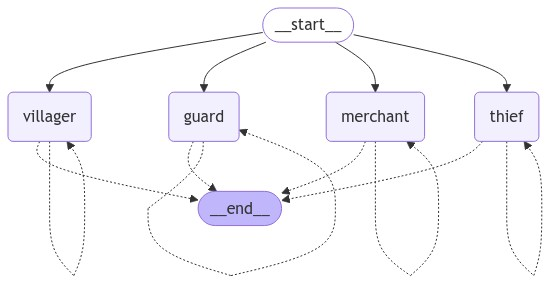

In [7]:
import * as tslab from "tslab";

const drawableGameGraph = await gameGraph.getGraphAsync();
const gameImage = await drawableGameGraph.drawMermaidPng();
const gameArrayBuffer = await gameImage.arrayBuffer();

await tslab.display.png(new Uint8Array(gameArrayBuffer));

Let's run it with some initial state!

In [8]:
const gameStream = await gameGraph.stream({
  wood: 10,
  food: 3,
  gold: 10,
  guardOnDuty: true,
}, {
  streamMode: "values",
});

for await (const state of gameStream) {
  console.log("Game state", state);
  console.log("-".repeat(50));
}

Game state { wood: 10, food: 3, gold: 10, guardOnDuty: true }
--------------------------------------------------
Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state { wood: 8, food: 3, gold: 11, guardOnDuty: true }
--------------------------------------------------
Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state { wood: 6, food: 3, gold: 12, guardOnDuty: true }
--------------------------------------------------
Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state { wood: 4, food: 3, gold: 13, guardOnDuty: true }
--------------------------------------------------
Villager gathering resources.
Guard patrolling.
Game state { wood: 7, food: 3, gold: 13, guardOnDuty: true }
--------------------------------------------------
Villager gathering resources.
Guard patrolling.
Game state { wood: 10, food: 3, gold: 13, guardOnDuty: true }
-----------------------------------------